<a href="https://colab.research.google.com/github/ryzhokhina/Tensorflow-Dev-Exam-Preparation/blob/main/NLP/nlp_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-27 01:10:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-27 01:10:30 (58.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

# Load data

In [ ]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-07-27 01:10:50--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K   987KB/s    in 0.6s    

2023-07-27 01:10:51 (987 KB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#Load a pretrained encoder - USA - universal sentense encoder

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
test_sencence = train_df["text"][0]
test_sencence


'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [ ]:
embedding_text = embed([test_sencence])
embedding_text.shape


TensorShape([1, 512])

# Split data to train and validate sets


In [ ]:
from sklearn.model_selection import train_test_split


# Split data to train and validate sets
x_train, x_valid, y_train, y_valid = train_test_split(train_df["text"],
                                                      train_df["target"],
                                                      test_size=0.2,
                                                      random_state=42)


In [ ]:
x_train.head()

4996    Courageous and honest analysis of need to use ...
3263    @ZachZaidman @670TheScore wld b a shame if tha...
4907    Tell @BarackObama to rescind medals of 'honor'...
2855    Worried about how the CA drought might affect ...
4716    @YoungHeroesID Lava Blast &amp; Power Red #Pan...
Name: text, dtype: object

In [ ]:
x_valid.head()

2644    So you have a new weapon that can cause un-ima...
2227    The f$&amp;@ing things I do for #GISHWHES Just...
5448    DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...
132     Aftershock back to school kick off was great. ...
6845    in response to trauma Children of Addicts deve...
Name: text, dtype: object

# Create a model to classification using USA embedding

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout
from tensorflow.keras.models import Model


In [ ]:
# create encodel layer
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                         input_shape=[],
                         dtype=tf.string,
                         trainable=False,
                         name="encoder")


In [70]:
def create_model():
    inputs = tf.keras.Input(shape=tf.shape(''), dtype=tf.string)
    x = encoder(inputs)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=x)

    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["accuracy"])

    return model

In [71]:
model = create_model()
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None,)]                 0         
                                                                 
 encoder (KerasLayer)        (None, 512)               256797824 
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 32)                4128      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 33  

In [72]:
MC = tf.keras.callbacks.ModelCheckpoint("model.h5", monitor="val_accuracy", save_best_only=True)
ES = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)
LRC = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", patience=5, factor=0.2, min_lr=0.00001)

history = model.fit(
    x_train,
    y_train, epochs=100,
    validation_data=(x_valid, y_valid),
    callbacks = [MC, ES, LRC])


Epoch 1/100
191/191 [==============================] - 18s 64ms/step - loss: 0.5170 - accuracy: 0.7741 - val_loss: 0.4178 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 2/100
191/191 [==============================] - 10s 50ms/step - loss: 0.4156 - accuracy: 0.8184 - val_loss: 0.4059 - val_accuracy: 0.8240 - lr: 0.0010
Epoch 3/100
191/191 [==============================] - 12s 61ms/step - loss: 0.3930 - accuracy: 0.8314 - val_loss: 0.4090 - val_accuracy: 0.8267 - lr: 0.0010
Epoch 4/100
191/191 [==============================] - 11s 59ms/step - loss: 0.3739 - accuracy: 0.8438 - val_loss: 0.4061 - val_accuracy: 0.8293 - lr: 0.0010
Epoch 5/100
191/191 [==============================] - 3s 17ms/step - loss: 0.3559 - accuracy: 0.8524 - val_loss: 0.4048 - val_accuracy: 0.8273 - lr: 0.0010
Epoch 6/100
191/191 [==============================] - 5s 24ms/step - loss: 0.3372 - accuracy: 0.8603 - val_loss: 0.4156 - val_accuracy: 0.8280 - lr: 0.0010
Epoch 7/100
191/191 [==============================] -

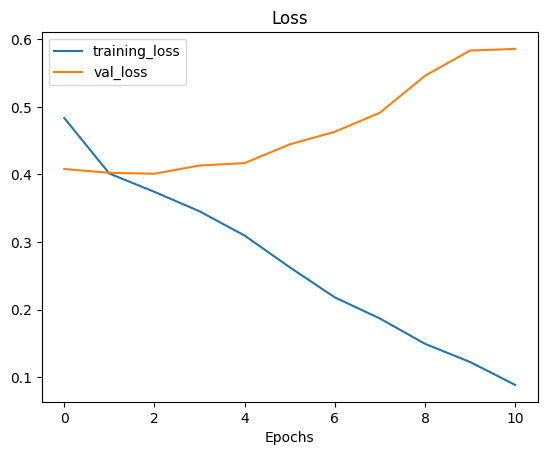

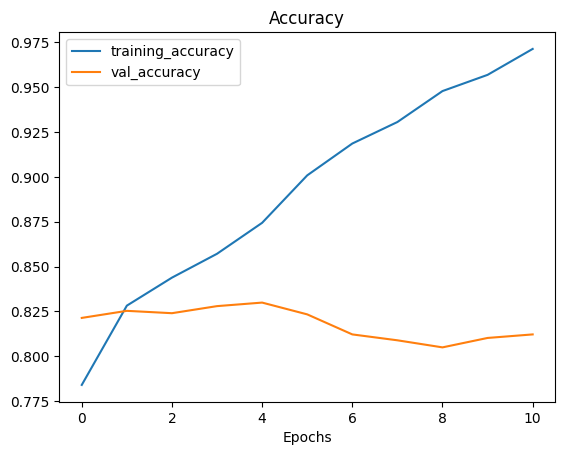

In [67]:
plot_loss_curves(history)


In [68]:
model.evaluate(x_valid, y_valid)


48/48 [==============================] - 1s 20ms/step - loss: 0.4166 - accuracy: 0.8299


[0.41664981842041016, 0.829940915107727]

In [62]:
model.save('/content/drive/MyDrive/ai_model/best_model.h5')

In [60]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None,)]                 0         
                                                                 
 encoder (KerasLayer)        (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 16)                8208      
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 256,806,049
Trainable params: 8,225
Non-trainable params: 256,797,824
_________________________________________________________________
